In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import re
import shutil
import time
from datetime import datetime
from datetime import timedelta
pd.set_option('display.max_columns',None)
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [15]:
'''loading data'''
path=os.getcwd()
df=pd.read_excel(path+'\\datasource.xlsx',sheet_name='甘特图',parse_dates=True)
display('df','df.describe()')

,Task,Department,Start,End,Completion
0,TSK-M,IT,2022-03-17,2022-03-20,0.0
1,TSK-N,MKT,2022-03-17,2022-03-19,0.0
2,TSK-L,ENG,2022-03-10,2022-03-13,0.0
3,TSK-K,PROD,2022-03-09,2022-03-13,0.0
4,TSK-J,PROD,2022-03-04,2022-03-17,0.0
5,TSK-H,FIN,2022-02-28,2022-03-02,1.0
6,TSK-I,MKT,2022-02-28,2022-03-05,0.4
7,TSK-G,FIN,2022-02-27,2022-03-03,0.7
8,TSK-F,MKT,2022-02-26,2022-02-27,1.0
9,TSK-E,ENG,2022-02-23,2022-03-09,0.5


In [39]:
'''计算子项目以及整体项目花费时间'''
proj_start = df.Start.min()  # whole project start date
print(proj_start)
df['start_num'] = (df.Start - proj_start).dt.days   # number of days from project start to task start
df['end_num'] = (df.End - proj_start).dt.days       # number of days from project start to end of tasks
df['days_start_to_end'] = df.end_num - df.start_num # days between start and end of each task
# create a column with the color for each department
def color(row):
    c_dict = {'MKT':'#E64646', 'FIN':'#E69646', 'ENG':'#34D05C',
              'PROD':'#34D0C3', 'IT':'#3475D0'}
    return c_dict[row['Department']]
df['color'] = df.apply(color, axis=1)
# days between start and current progression of each task
df['current_num'] = df.days_start_to_end * df.Completion
df

2022-02-15 00:00:00


,Task,Department,Start,End,Completion,start_num,end_num,days_start_to_end,color,current_num
0,TSK-M,IT,2022-03-17,2022-03-20,0.0,30,33,3,#3475D0,0.0
1,TSK-N,MKT,2022-03-17,2022-03-19,0.0,30,32,2,#E64646,0.0
2,TSK-L,ENG,2022-03-10,2022-03-13,0.0,23,26,3,#34D05C,0.0
3,TSK-K,PROD,2022-03-09,2022-03-13,0.0,22,26,4,#34D0C3,0.0
4,TSK-J,PROD,2022-03-04,2022-03-17,0.0,17,30,13,#34D0C3,0.0
5,TSK-H,FIN,2022-02-28,2022-03-02,1.0,13,15,2,#E69646,2.0
6,TSK-I,MKT,2022-02-28,2022-03-05,0.4,13,18,5,#E64646,2.0
7,TSK-G,FIN,2022-02-27,2022-03-03,0.7,12,16,4,#E69646,2.8
8,TSK-F,MKT,2022-02-26,2022-02-27,1.0,11,12,1,#E64646,1.0
9,TSK-E,ENG,2022-02-23,2022-03-09,0.5,8,22,14,#34D05C,7.0


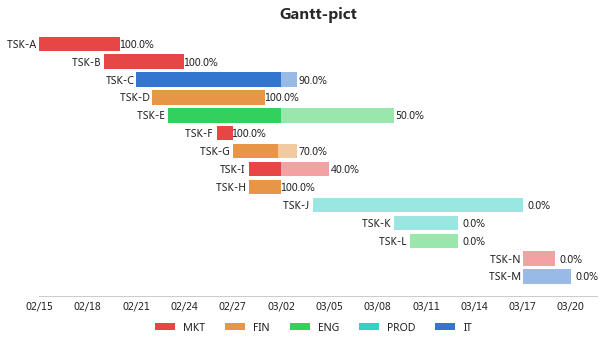

In [79]:
'''setting parameters'''
%matplotlib inline
import matplotlib.style as style
from matplotlib.ticker import FuncFormatter
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus']=False
from matplotlib.patches import Patch

fig=plt.figure(figsize=(10,5))
plt.barh(df.Task, df.current_num, left=df.start_num, color=df['color'])#已完成工程
plt.barh(df.Task, df.days_start_to_end, left=df.start_num,color=df['color'],alpha=0.5)#全部工程 透明度

'''设定xtick'''
xticks = np.arange(0, df.end_num.max()+1, 3) #在x轴范围内 间隔步数为3
xticks_labels = pd.date_range(proj_start, end=df.End.max()).strftime("%m/%d")#设定x轴label转为月日形式
plt.xticks(xticks,xticks_labels[::3]) #变换x轴 间隔步数为3

'''添加侧标'''
#添加数字侧标
for a, b,c in zip(df['days_start_to_end']+df['start_num'],df.index,df['Completion']):
    plt.text(a+1, b, '{}%'.format(round(c*100, 1)),ha='center', va='center', fontsize=10)
#添加文字侧标
for d,e,f in zip(df['start_num'],df.index,df['Task']):
    plt.text(d-1, e, '{}'.format(f),ha='center', va='center', fontsize=10)
    
'''设定legend'''
c_dict = {'MKT':'#E64646', 'FIN':'#E69646', 'ENG':'#34D05C', 'PROD':'#34D0C3', 'IT':'#3475D0'}
legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
plt.legend(handles=legend_elements,loc=(0.2,-0.15),ncol=5)

'''优化界面'''
plt.grid(color='white') #去除网格
plt.gca().spines['left'].set_color('none')#去轴
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.yticks([])#去除轴坐标

#对整体图像设置标题
plt.title('Gantt-pict',fontsize=15,fontweight='bold')
plt.show()

In [81]:
?plt.barh